# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='./data')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

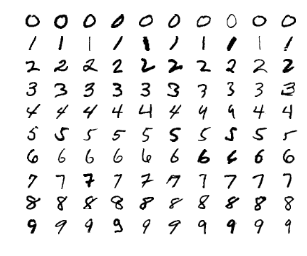

In [4]:
def P1(num_examples=10):

### STUDENT START ###

    if num_examples < 1: raise Exception('Need at least 1 example')
    plt.rc('image',cmap='gist_yarg')
    fig, axes = plt.subplots(10,num_examples)
    fig.set_figheight(10/2.5)
    fig.set_figwidth(num_examples/2)
    for i in range(10):
        labelnums = [ m for m,y in enumerate(mini_train_labels) if y==i ]
        for x in range(num_examples):
            trainnum = labelnums[x]
            if num_examples != 1:
                axes[i,x].imshow(mini_train_data[trainnum].reshape((28,28)))
                axes[i,x].axis('off')
            else:
                axes[i].imshow(mini_train_data[trainnum].reshape((28,28)))
                axes[i].axis('off')

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
def P2(k_values):

### STUDENT START ###
    ks = [ KNeighborsClassifier(n_neighbors = k) for k in k_values ]
    accuracies = []
    for i,k in enumerate(k_values):
        ks[i].fit(mini_train_data, mini_train_labels)
        predictions = ks[i].predict(dev_data)
        results = zip(predictions, dev_labels)
        accuracy = round(sum(map(lambda x: x[0]==x[1], results))*1.0 / len(results),2)
        accuracies.append((k,accuracy))
        if k==1: 
            print classification_report(predictions, dev_labels)
    
    return accuracies

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

             precision    recall  f1-score   support

        0.0       0.98      0.91      0.94       107
        1.0       1.00      0.89      0.94       118
        2.0       0.79      0.99      0.88        82
        3.0       0.87      0.77      0.82        97
        4.0       0.82      0.89      0.85        96
        5.0       0.84      0.93      0.88        82
        6.0       0.96      0.94      0.95       100
        7.0       0.92      0.89      0.90       117
        8.0       0.88      0.94      0.91        89
        9.0       0.82      0.78      0.80       112

avg / total       0.89      0.89      0.89      1000



[(1, 0.89), (3, 0.88), (5, 0.87), (7, 0.86), (9, 0.86)]

ANSWER: 

Accuracies:
k=1: 89%
k=3: 88%
k=5: 87%
k=7: 86%
k=9: 86%

The most difficult digit to predict is digit '9', based on the f1-score, which is a weighted harmonic mean of the precision and recall metrics. The digit '9' has the lowest precision score - which is tp / (tp + fp), or intuitively the ability of the classifier not to label as positive a sample that is negative - and it has second lowest recall - which is tp / (tp + fn), or intuitively the ability of the classifier to find all the positive samples. (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [6]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    from numpy import mean 
    
    ks = [ KNeighborsClassifier(n_neighbors = 1) for k in train_sizes ]
    times = []
    
    for i,k in enumerate(train_sizes):
        ks[i].fit(train_data[:k], train_labels[:k])
        start = time.time()
        predictions = ks[i].predict(dev_data)
        end = time.time()
        times.append((k,round(end-start,4)))
        results = zip(predictions, dev_labels)
        # accuracy = round(sum(map(lambda x: x[0]==x[1], results))*1.0 / len(results),3)
        accuracy = mean([ x[0]==x[1] for x in results ])
        accuracies.append((k,accuracy))
    
    accuracy_strs = ['For size {0}, accuracy was {1}%'.format(k,a*100) for k,a in accuracies ]
    time_strs = ['& time for prediction was {1} seconds'.format(k, t) for k,t in times]
    all_strs = zip(accuracy_strs,time_strs)
    all_strs = map(lambda x: ' '.join(x), all_strs)
    
    print '\n'.join(all_strs)
    return accuracies

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For size 100, accuracy was 72.0% & time for prediction was 0.1118 seconds
For size 200, accuracy was 78.6% & time for prediction was 0.2208 seconds
For size 400, accuracy was 84.1% & time for prediction was 0.4253 seconds
For size 800, accuracy was 88.4% & time for prediction was 0.8792 seconds
For size 1600, accuracy was 90.2% & time for prediction was 1.8945 seconds
For size 3200, accuracy was 92.6% & time for prediction was 3.8616 seconds
For size 6400, accuracy was 93.7% & time for prediction was 8.1467 seconds
For size 12800, accuracy was 95.9% & time for prediction was 15.111 seconds
For size 25000, accuracy was 97.0% & time for prediction was 37.184 seconds


[(100, 0.71999999999999997),
 (200, 0.78600000000000003),
 (400, 0.84099999999999997),
 (800, 0.88400000000000001),
 (1600, 0.90200000000000002),
 (3200, 0.92600000000000005),
 (6400, 0.93700000000000006),
 (12800, 0.95899999999999996),
 (25000, 0.96999999999999997)]

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [7]:
def P4():

### STUDENT START ###
    from math import log, exp
    accuracies = [(100, 0.72),
                 (200, 0.786),
                 (400, 0.841),
                 (800, 0.884),
                 (1600, 0.902),
                 (3200, 0.926),
                 (6400, 0.937),
                 (12800, 0.959),
                 (25000, 0.97)]
    size, accuracy = zip(*accuracies)
    vectorize = lambda x: [x]
    size = map(vectorize, size)
    accuracy_rate = map(vectorize, accuracy)
    accuracy_log = map(lambda x: [log(1-x)], accuracy)
    lm = LinearRegression()
    lm_log = LinearRegression()
    lm.fit(size, accuracy_rate)
    lm_log.fit(size, accuracy_log)
    print str(round(lm.predict(60000)[0][0],3)*100)+'%'
    print str(round(1-exp(lm_log.predict(60000)[0][0]),3)*100)+'%'

### STUDENT END ###

P4()

124.3%
99.8%


ANSWER:

The prediction from a linear regression model is 124%, which is nonsensical since it is above 100%. 
A transformation can be made by taking the log of 1 minus accuracy, and then take the exponent of the predicted value and subtract from 1. The result will never be above 100% in this case. An example of this transformation is shown above.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

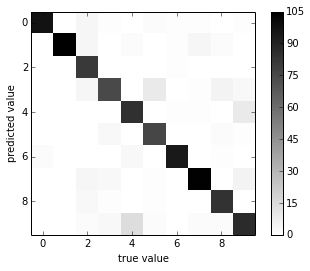

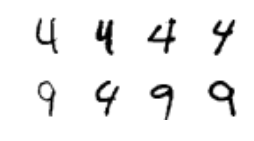

In [8]:
def P5():

### STUDENT START ###
    def plot_confusion_matrix(y_pred, y):
        ''' http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/18_IntermediateSklearn
        '''
        plt.imshow(confusion_matrix(y, y_pred),
               cmap=plt.cm.binary, interpolation='nearest')
        plt.colorbar()
        plt.xlabel('true value')
        plt.ylabel('predicted value')
    
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(mini_train_data, mini_train_labels)
    predictions = knn.predict(dev_data)
    plot_confusion_matrix(dev_labels, predictions)
    
    results = zip(dev_labels,predictions)
    incorrect_4s = [ i for i,r in enumerate(results) if r[0]==4 and r[1]==9]
    incorrect_9s = [ i for i,r in enumerate(results) if r[0]==9 and r[1]==4]
    
    fig, axes = plt.subplots(2,4)
    fig.set_figheight(2)
    fig.set_figwidth(4)
    for i in range(4):
        axes[0,i].imshow(dev_data[incorrect_4s[i]].reshape((28,28)))
        axes[0,i].axis('off')
    for i in range(4):
        axes[1,i].imshow(dev_data[incorrect_9s[i]].reshape((28,28)))
        axes[1,i].axis('off')
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Accuracy in case "preprocess the training data but not the dev data" was 88.8%
Accuracy in case "preprocess the dev data but not the training data" was 88.3%
Accuracy in case "preprocess both training and dev data" was 89.2%


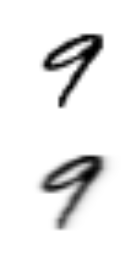

In [15]:
def P6():
    
### STUDENT START ###
    
    from math import pi, e, sqrt
    from numpy import mean
    
    def gauss(xblock, sigma=1):
        ''' Return sum of gaussian-weighted values
            where origin is the middle value
        '''
        xn = np.zeros(len(xblock))
        for i in range(len(xblock)): 
            xn[i] = i-len(xblock)//2
            xn[i] = (1.0 / sqrt(2*pi*sigma**2)) * e**(-1.0*(xn[i]**2)/(2*sigma**2))
        return sum(xn*xblock)
    
    def blur(arr):
        ''' Iterate through a pixel array and return
            a new array that is blurred using 
            gaussian function 
        '''
        arrnew = arr.copy()
        for i in range(len(arrnew)):
            arrnew[i] = gauss(arrnew[i-4:i+5])
        return arrnew
    
    def show_example(index):
        ''' Function to display two images
            First is unblurred
            Second with blur function
        '''
        fig, axes = plt.subplots(2,1)
        axes[0].imshow(mini_train_data[index].reshape((28,28)))
        axes[0].axis('off')
        x = blur(mini_train_data[index])
        axes[1].imshow(x.reshape((28,28)))
        axes[1].axis('off')
    
    def run_model():
        ''' Blur datasets, and run classification model
        '''
        
        ''' Blur datasets '''
        blurred_train = mini_train_data.copy()
        blurred_dev = dev_data.copy()
        for i in range(len(blurred_train)): blurred_train[i] = blur(mini_train_data[i])
        for i in range(len(blurred_dev)): blurred_dev[i] = blur(dev_data[i])

        ''' Create classifiers '''
        knn_1 = KNeighborsClassifier(n_neighbors = 1)
        knn_2 = KNeighborsClassifier(n_neighbors = 1)
        knn_3 = KNeighborsClassifier(n_neighbors = 1)

        ''' Fit classifiers'''
        knn_1.fit(blurred_train, mini_train_labels)
        knn_2.fit(mini_train_data, mini_train_labels)
        knn_3.fit(blurred_train, mini_train_labels)

        ''' Make predictions '''
        predictions_1 = zip(knn_1.predict(dev_data),dev_labels)
        predictions_2 = zip(knn_2.predict(blurred_dev),dev_labels)
        predictions_3 = zip(knn_3.predict(blurred_dev),dev_labels)

        ''' Measure accuracies '''
        accuracy_1 = mean([x[0]==x[1] for x in predictions_1 ])
        accuracy_2 = mean([x[0]==x[1] for x in predictions_2 ])
        accuracy_3 = mean([x[0]==x[1] for x in predictions_3 ])

        ''' Report on accuracy '''
        reportstr = 'Accuracy in case "{0}" was {1}%'
        print reportstr.format('preprocess the training data but not the dev data',round(accuracy_1,3)*100)
        print reportstr.format('preprocess the dev data but not the training data',round(accuracy_2,3)*100)
        print reportstr.format('preprocess both training and dev data',round(accuracy_3,3)*100)
    
    show_example(15)
    run_model()
    
### STUDENT END ###

P6()

ANSWER:

Accuracy in case "preprocess the training data but not the dev data" was 88.8%
Accuracy in case "preprocess the dev data but not the training data" was 88.3%
Accuracy in case "preprocess both training and dev data" was 89.2%

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [45]:
def P7():

### STUDENT START ###
    nbb = BernoulliNB(binarize=0.5)
    nbb.fit(mini_train_data, mini_train_labels)
    nbb_predictions = nbb.predict(dev_data)
    
    def multi_apply(arr):
        ''' Take an array of pictures with pixel values
            mapped to 0, 1, or 2 representing white, 
            grey, or black.
        '''
        newarr = arr.copy()
        
        def check_val(x):
            if x<0.34: return 0 
            elif x<=0.66: return 1
            else: return 2
        
        for i in range(arr.shape[0]):
            newarr[i] = [ check_val(z) for z in arr[i] ]
        
        return newarr
    
    multi_train_data, multi_dev_data = np.zeros(mini_train_data.shape[0]), np.zeros(dev_data.shape[0])
    multi_train_data, multi_dev_data = multi_apply(mini_train_data), multi_apply(dev_data)
    nbm = MultinomialNB()
    nbm.fit(multi_train_data, mini_train_labels)
    nbm_predictions = nbm.predict(multi_dev_data)
    
    print 'Bernoulli model report:\n', \
        classification_report(nbb_predictions,dev_labels), \
        'Multinomial model report:\n', \
        classification_report(nbm_predictions,dev_labels)
    
### STUDENT END ###

P7()

Bernoulli model report:
             precision    recall  f1-score   support

        0.0       0.98      0.91      0.94       107
        1.0       0.93      0.82      0.87       119
        2.0       0.79      0.85      0.82        95
        3.0       0.74      0.62      0.67       104
        4.0       0.79      0.90      0.84        91
        5.0       0.62      0.85      0.71        66
        6.0       0.87      0.89      0.88        95
        7.0       0.80      0.92      0.85        98
        8.0       0.80      0.75      0.77       103
        9.0       0.82      0.71      0.76       122

avg / total       0.82      0.82      0.82      1000
Multinomial model report:
             precision    recall  f1-score   support

        0.0       0.97      0.90      0.93       107
        1.0       0.92      0.87      0.90       111
        2.0       0.81      0.84      0.83        99
        3.0       0.74      0.65      0.69        99
        4.0       0.69      0.92      0.79    

ANSWER:

The multi-class version makes the overall performance of the model worse. Recall for some numbers, such as the numbers 1 and 3, are improved, while the majority of the numbers are better off in the binary model.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [12]:
#def P8(alphas):

### STUDENT START ###



### STUDENT END ###

#alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
#nb = P8(alphas)

In [14]:
#print nb.best_params_

ANSWER:

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [15]:
#def P9():

### STUDENT END ###


### STUDENT END ###

#gnb = P9()

ANSWER:

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [16]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [17]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

#buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
#correct = [0 for i in buckets]
#total = [0 for i in buckets]

#P11(buckets, correct, total)

#for i in range(len(buckets)):
#    accuracy = 0.0
#    if (total[i] > 0): accuracy = correct[i] / total[i]
#    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()